In [1]:
# 0) get data path (i.e. voxceleb-fairness/data/datasets/no_cuda/)
# 0.1) get the test list(s) path
# 1) get the saved model path
# 2) call SpeakerNet.loadparams(path)
# 3) use validation code from train script

In [2]:
import sys, os
sys.path.insert(0, '/home/jupyter/voxceleb-fairness/common/')

In [3]:
import pwd
import pdb
import glob
import time
import yaml
import wandb
import numpy
import torch
import json
import random
import google
from sklearn import metrics
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import time, os, argparse, socket
from SpeakerNet import SpeakerNet
from IterableTrainDataset import IterableTrainDataset
from baseline_misc.tuneThreshold import tuneThresholdfromScore
from utils.data_utils import download_gcs_dataset, extract_gcs_dataset, \
                     transcode_gcs_dataset, get_loc_paths_from_gcs_dataset,\
                     download_blob, upload_blob

In [4]:
parser = argparse.ArgumentParser(description = "SpeakerNet");

parser.add_argument('--set-seed', action='store_true')
parser.add_argument('--no-cuda', action='store_true', help="Flag to disable cuda for this run")

parser.add_argument('--checkpoint-bucket', type=str,
        default="voxsrc-2020-checkpoints-dev");

# new training params
parser.add_argument('--gaussian-noise-std', type=float, default=.9,
        help="Standard deviation of gaussian noise used to augment utterance "
             "spectrogram training data");

## Data loader
parser.add_argument('--max_frames', type=int, default=200,  help='Input length to the network');
parser.add_argument('--batch_size', type=int, default=200,  help='Batch size');
# @TODO figure out max eval batch size for this on V100
parser.add_argument('--eval_batch_size', type=int, default=85,  help='Batch size for loading validation data for model eval');
# ^^^ use --batch_size=30 for small datasets that can't fill an entire 200 speaker pair/triplet batch
parser.add_argument('--max_seg_per_spk', type=int, default=100, help='Maximum number of utterances per speaker per epoch');
parser.add_argument('--n-data-loader-thread', type=int, default=7, help='Number of loader threads');

## Training details
# @TODO disentangle learning rate decay from validation
parser.add_argument('--test_interval', type=int, default=10, help='Test and save every [test_interval] epochs');
parser.add_argument('--max_epoch',      type=int, default=100, help='Maximum number of epochs');
# ^^^ use --max_epoch=1 for local testing
parser.add_argument('--trainfunc', type=str, default="angleproto",    help='Loss function');
parser.add_argument('--optimizer', type=str, default="adam", help='sgd or adam');

## Learning rates
parser.add_argument('--lr', type=float, default=0.001,      help='Learning rate');
parser.add_argument('--lr_decay_interval', type=int, default=10, help='Reduce the learning rate every [lr_decay_interval] epochs');
parser.add_argument("--lr_decay", type=float, default=0.95, help='Learning rate decay every [test_interval] epochs');

## Loss functions
parser.add_argument("--hard_prob", type=float, default=0.5, help='Hard negative mining probability, otherwise random, only for some loss functions');
parser.add_argument("--hard_rank", type=int, default=10,    help='Hard negative mining rank in the batch, only for some loss functions');
parser.add_argument('--margin', type=float,  default=0.3,     help='Loss margin, only for some loss functions');
parser.add_argument('--scale', type=float,   default=30,    help='Loss scale, only for some loss functions');
parser.add_argument('--nSpeakers', type=int, default=5994,  help='Number of speakers in the softmax layer for softmax-based losses, utterances per speaker per iteration for other losses');

## Load and save
parser.add_argument('--initial_model',  type=str, default="", help='Initial model weights');
parser.add_argument('--save_path',      type=str, default="/tmp/data/exp1", help='Path for model and logs');

## Training and test data
parser.add_argument('--train_list', type=str, help='Train list');
parser.add_argument('--test_list',  type=str, help='Evaluation list');
parser.add_argument('--train_path', type=str, default="voxceleb2", help='Absolute path to the train set');
parser.add_argument('--test_path',  type=str, default="voxceleb1", help='Absolute path to the test set');

## For test only
parser.add_argument('--eval', dest='eval', action='store_true', help='Eval only')

## Model definition
parser.add_argument('--model', type=str,        default="ResNetSE34L",     help='Name of model definition');
parser.add_argument('--encoder_type', type=str, default="SAP",  help='Type of encoder');
parser.add_argument('--nOut', type=int,         default=512,    help='Embedding size in the last FC layer');

args = parser.parse_args("");


# set random seeds
# @TODO any reason to use BOTH 'random' and 'numpy.random'?
if args.set_seed:
    print("train: Using fixed random seed")
    random.seed(0)
    numpy.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)


# set torch device to cuda or cpu
cuda_avail = torch.cuda.is_available()
print(f"train: Cuda available: {cuda_avail}")
use_cuda = cuda_avail and not args.no_cuda
print(f"train: Using cuda: {use_cuda}")
device = torch.device("cuda" if use_cuda else "cpu")
print(f"train: Torch version: {torch.__version__}")
print(f"train: Cuda version: {torch.version.cuda}")

train: Cuda available: True
train: Using cuda: True
train: Torch version: 1.6.0
train: Cuda version: 10.2


In [5]:
## Load models
s = SpeakerNet(device, **vars(args));

Embedding size is 512, encoder SAP.
Initialised AngleProto


In [6]:
s.loadParameters("/home/jupyter/model000000029.model")

Loading model from path /home/jupyter/model000000029.model


In [7]:
male_scores, male_labels = s.evaluate_on('/home/jupyter/voxceleb-fairness/data/lists/vox1_male_all_balanced.txt', 
                                         '/home/jupyter/voxceleb-fairness/data/datasets/full/vox1_full_feats_milo_webster-19rvuxfu')





SpeakerNet: Starting model eval on 59 batches of size 85
IterableEvalDataset: Starting worker thread #0IterableEvalDataset: Starting worker thread #1IterableEvalDataset: Starting worker thread #2IterableEvalDataset: Starting worker thread #3



IterableEvalDataset: Starting worker thread #4
IterableEvalDataset: Starting worker thread #5IterableEvalDataset: Starting worker thread #6

IterableEvalDataset: Stopping worker #3
IterableEvalDataset: Stopping worker #4
IterableEvalDataset: Stopping worker #5
IterableEvalDataset: Stopping worker #6
IterableEvalDataset: Stopping worker #0
IterableEvalDataset: Stopping worker #1
IterableEvalDataset: Stopping worker #2
SpeakerNet: Computed utterance segment embeddings in 49.249743700027466 (s)
SpeakerNet: Computed utterance test pair scores in 19.09455895423889 (s)


In [8]:
female_scores, female_labels = s.evaluate_on('/home/jupyter/voxceleb-fairness/data/lists/vox1_female_all_balanced.txt', '/home/jupyter/voxceleb-fairness/data/datasets/full/vox1_full_feats_milo_webster-19rvuxfu')

SpeakerNet: Starting model eval on 59 batches of size 85
IterableEvalDataset: Starting worker thread #0IterableEvalDataset: Starting worker thread #1IterableEvalDataset: Starting worker thread #2
IterableEvalDataset: Starting worker thread #4
IterableEvalDataset: Starting worker thread #3

IterableEvalDataset: Starting worker thread #5
IterableEvalDataset: Starting worker thread #6

IterableEvalDataset: Stopping worker #3
IterableEvalDataset: Stopping worker #4
IterableEvalDataset: Stopping worker #5
IterableEvalDataset: Stopping worker #6
IterableEvalDataset: Stopping worker #0
IterableEvalDataset: Stopping worker #1
IterableEvalDataset: Stopping worker #2
SpeakerNet: Computed utterance segment embeddings in 44.177271127700806 (s)
SpeakerNet: Computed utterance test pair scores in 21.60359287261963 (s)


In [9]:
male_fpr, male_tpr, male_thresholds = metrics.roc_curve(male_labels, male_scores, pos_label=1)
female_fpr, female_tpr, female_thresholds = metrics.roc_curve(female_labels, female_scores, pos_label=1)

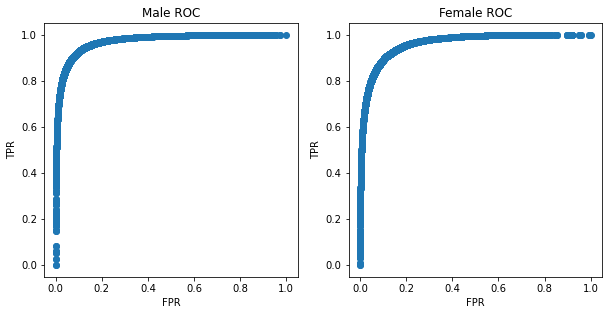

In [10]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(121)
ax.scatter(male_fpr, male_tpr)
ax.set_aspect(1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title('Male ROC')
ax = fig.add_subplot(122)
ax.scatter(female_fpr, female_tpr)
ax.set_aspect(1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title('Female ROC')
plt.show()

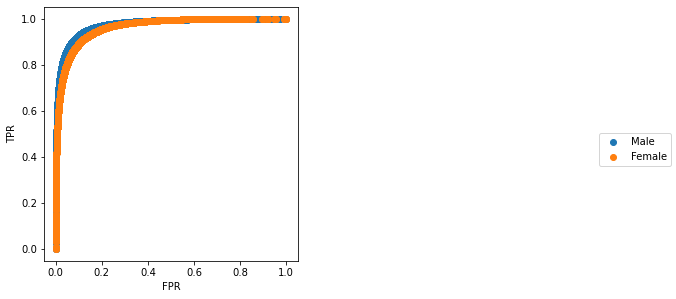

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.scatter(male_fpr, male_tpr, label='Male')
ax.scatter(female_fpr, female_tpr, label='Female')
ax.set_aspect(1)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
fig.legend(loc='center right')
plt.show()

In [12]:
results = {'male_fpr' : male_fpr.tolist(), 'male_tpr' : male_tpr.tolist(), 'male_thresholds' : male_thresholds.tolist(), 'female_fpr' : female_fpr.tolist(), 'female_tpr' : female_tpr.tolist(), 'female_thresholds' : female_thresholds.tolist()}

In [13]:
with open('/home/jupyter/results_new.json', 'w') as fp:
    json.dump(results, fp)